## Importación de las librerías

In [22]:
import utils
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

## Conjuntos de entrenamiento y test y CV controller

In [2]:
X_train, X_test, y_train, y_test = utils.get_train_test_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7776, 12) (1022, 12) (7776,) (1022,)


In [3]:
cv = utils.get_stratified_shuffle_cv()
print(cv)

StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8)


## Búsqueda de los hiperparámetros del árbol de clasificación

### Seleccionamos max_depth del árbol de clasificación

In [4]:
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [10, 20, 30, 40, 50, 100],
}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=99),
                              param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=3)
grid_search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ......criterion=gini, max_depth=10;, score=0.908 total time=   0.0s
[CV 2/5] END ......criterion=gini, max_depth=10;, score=0.928 total time=   0.0s
[CV 3/5] END ......criterion=gini, max_depth=10;, score=0.910 total time=   0.0s
[CV 4/5] END ......criterion=gini, max_depth=10;, score=0.912 total time=   0.0s
[CV 5/5] END ......criterion=gini, max_depth=10;, score=0.907 total time=   0.0s
[CV 1/5] END ......criterion=gini, max_depth=20;, score=0.924 total time=   0.0s
[CV 2/5] END ......criterion=gini, max_depth=20;, score=0.938 total time=   0.0s
[CV 3/5] END ......criterion=gini, max_depth=20;, score=0.927 total time=   0.0s
[CV 4/5] END ......criterion=gini, max_depth=20;, score=0.921 total time=   0.0s
[CV 5/5] END ......criterion=gini, max_depth=20;, score=0.923 total time=   0.0s
[CV 1/5] END ......criterion=gini, max_depth=30;, score=0.923 total time=   0.0s
[CV 2/5] END ......criterion=gini, max_depth=30;

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=DecisionTreeClassifier(random_state=99),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50, 100]},
             scoring='roc_auc', verbose=3)

Pintamos el **roc_auc medio en test de validación** a medida que aumenta el **max_depth** para cada uno de los distintos **criterios**

<AxesSubplot:xlabel='max_depth', ylabel='mean_test_score'>

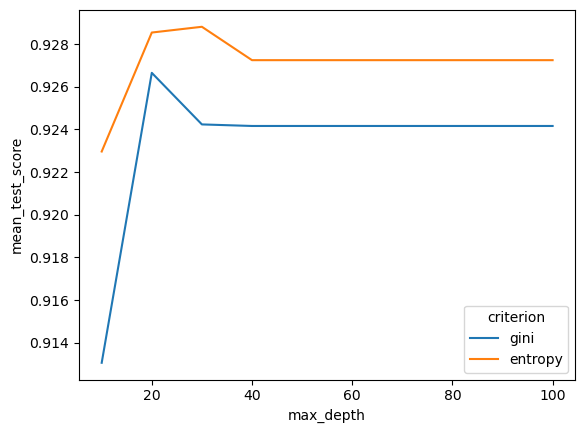

In [5]:
criterion_list = list(grid_search_cv.cv_results_['param_criterion'].data)
max_depth_list = list(grid_search_cv.cv_results_['param_max_depth'].data)
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])
max_depth_df = pd.DataFrame(list(zip(criterion_list, max_depth_list, mean_test_score_list)), columns=['criterion', 'max_depth', 'mean_test_score'])
sns.lineplot(data=max_depth_df, x="max_depth", y="mean_test_score", hue="criterion")

In [6]:
max_depth_df.sort_values(['criterion', 'mean_test_score', 'max_depth'], ascending=False)

,criterion,max_depth,mean_test_score
1,gini,20,0.926655
2,gini,30,0.924238
5,gini,100,0.924165
4,gini,50,0.924165
3,gini,40,0.924165
0,gini,10,0.913064
8,entropy,30,0.928814
7,entropy,20,0.928544
11,entropy,100,0.927249
10,entropy,50,0.927249


Para el modelo final se probarán todos los valores entre [20, 30] para el parámetro **max_depth**

In [7]:
max_depth_final_values = list(range(20,31))
max_depth_final_values

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

### Seleccionamos min_samples_leaf (minbucket) del árbol de clasificación

In [8]:
param_grid = {
    'criterion': ['gini','entropy'],
    'min_samples_leaf': list(range(5,51,5)),
}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=99),
                              param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=3)
grid_search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END criterion=gini, min_samples_leaf=5;, score=0.951 total time=   0.0s
[CV 2/5] END criterion=gini, min_samples_leaf=5;, score=0.962 total time=   0.0s
[CV 3/5] END criterion=gini, min_samples_leaf=5;, score=0.953 total time=   0.0s
[CV 4/5] END criterion=gini, min_samples_leaf=5;, score=0.948 total time=   0.0s
[CV 5/5] END criterion=gini, min_samples_leaf=5;, score=0.955 total time=   0.0s
[CV 1/5] END criterion=gini, min_samples_leaf=10;, score=0.961 total time=   0.0s
[CV 2/5] END criterion=gini, min_samples_leaf=10;, score=0.969 total time=   0.0s
[CV 3/5] END criterion=gini, min_samples_leaf=10;, score=0.964 total time=   0.0s
[CV 4/5] END criterion=gini, min_samples_leaf=10;, score=0.957 total time=   0.0s
[CV 5/5] END criterion=gini, min_samples_leaf=10;, score=0.966 total time=   0.0s
[CV 1/5] END criterion=gini, min_samples_leaf=15;, score=0.961 total time=   0.0s
[CV 2/5] END criterion=gini, min_samples_

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=DecisionTreeClassifier(random_state=99),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50]},
             scoring='roc_auc', verbose=3)

Pintamos el **roc_auc medio en test de validación** a medida que aumenta el min_samples_leaf para cada uno de los distintos criterios

<AxesSubplot:xlabel='min_samples_leaf', ylabel='mean_test_score'>

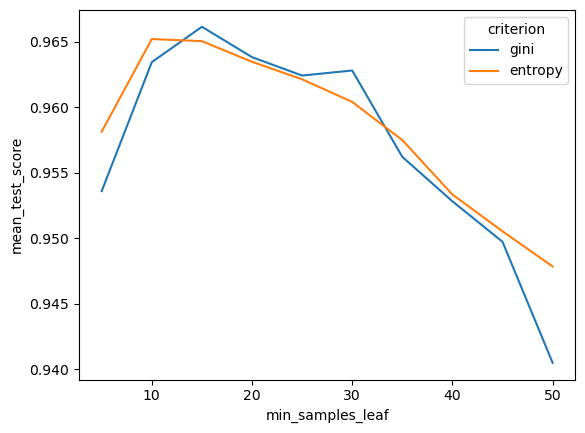

In [9]:
criterion_list = list(grid_search_cv.cv_results_['param_criterion'].data)
min_samples_leaf_list = list(grid_search_cv.cv_results_['param_min_samples_leaf'].data)
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])
min_samples_leaf_df = pd.DataFrame(list(zip(criterion_list, min_samples_leaf_list, mean_test_score_list)), columns=['criterion', 'min_samples_leaf', 'mean_test_score'])
sns.lineplot(data=min_samples_leaf_df, x="min_samples_leaf", y="mean_test_score", hue="criterion")

In [10]:
min_samples_leaf_df.sort_values(['criterion', 'mean_test_score', 'min_samples_leaf'], ascending=False)

,criterion,min_samples_leaf,mean_test_score
2,gini,15,0.966157
3,gini,20,0.963840
1,gini,10,0.963456
5,gini,30,0.962819
4,gini,25,0.962434
6,gini,35,0.956225
0,gini,5,0.953610
7,gini,40,0.952832
8,gini,45,0.949742
9,gini,50,0.940501


Para el modelo final se probarán todos los valores entre [10, 20] para el parámetro **min_samples_leaf**

In [11]:
min_samples_leaf_final = list(range(10,21))
min_samples_leaf_final

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

### Seleccionamos min_samples_split del árbol de clasificación

In [12]:
param_grid = {
    'criterion': ['gini','entropy'],
    'min_samples_split': list(range(5,51,5)),
}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=99),
                              param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=3)
grid_search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END criterion=gini, min_samples_split=5;, score=0.928 total time=   0.0s
[CV 2/5] END criterion=gini, min_samples_split=5;, score=0.939 total time=   0.0s
[CV 3/5] END criterion=gini, min_samples_split=5;, score=0.937 total time=   0.0s
[CV 4/5] END criterion=gini, min_samples_split=5;, score=0.935 total time=   0.0s
[CV 5/5] END criterion=gini, min_samples_split=5;, score=0.938 total time=   0.0s
[CV 1/5] END criterion=gini, min_samples_split=10;, score=0.944 total time=   0.0s
[CV 2/5] END criterion=gini, min_samples_split=10;, score=0.954 total time=   0.0s
[CV 3/5] END criterion=gini, min_samples_split=10;, score=0.945 total time=   0.0s
[CV 4/5] END criterion=gini, min_samples_split=10;, score=0.948 total time=   0.0s
[CV 5/5] END criterion=gini, min_samples_split=10;, score=0.947 total time=   0.0s
[CV 1/5] END criterion=gini, min_samples_split=15;, score=0.950 total time=   0.0s
[CV 2/5] END criterion=gini, m

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=DecisionTreeClassifier(random_state=99),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40,
                                               45, 50]},
             scoring='roc_auc', verbose=3)

Pintamos el **roc_auc medio en test de validación** a medida que aumenta el min_samples_split para cada uno de los distintos criterios

<AxesSubplot:xlabel='min_samples_split', ylabel='mean_test_score'>

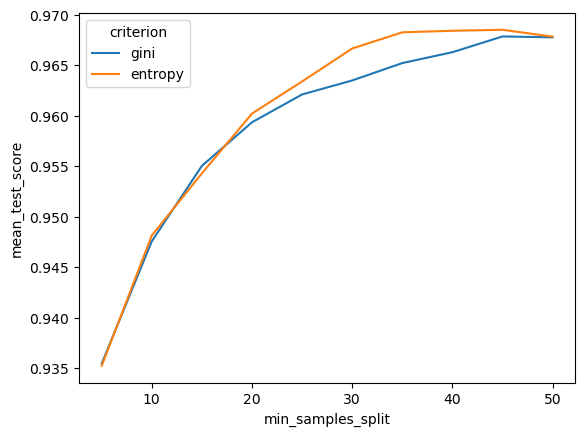

In [13]:
criterion_list = list(grid_search_cv.cv_results_['param_criterion'].data)
min_samples_split_list = list(grid_search_cv.cv_results_['param_min_samples_split'].data)
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])
min_samples_split_df = pd.DataFrame(list(zip(criterion_list, min_samples_split_list, mean_test_score_list)), columns=['criterion', 'min_samples_split', 'mean_test_score'])
sns.lineplot(data=min_samples_split_df, x="min_samples_split", y="mean_test_score", hue="criterion")

In [14]:
min_samples_split_df.sort_values(['criterion', 'mean_test_score', 'min_samples_split'], ascending=False)

,criterion,min_samples_split,mean_test_score
8,gini,45,0.967846
9,gini,50,0.967759
7,gini,40,0.966285
6,gini,35,0.965209
5,gini,30,0.963487
4,gini,25,0.962100
3,gini,20,0.959344
2,gini,15,0.955026
1,gini,10,0.947556
0,gini,5,0.935440


Para el modelo final se probarán todos los valores entre [40, 50] para el parámetro **min_samples_split**

In [15]:
min_samples_split_final = list(range(40,51))
min_samples_split_final

[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

## Búsqueda del mejor árbol de clasificación

In [17]:
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': max_depth_final_values,
    'min_samples_leaf': min_samples_leaf_final,
    'min_samples_split': min_samples_split_final
}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=99),
                              param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=0, n_jobs=-1)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=DecisionTreeClassifier(random_state=99), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                       30],
                         'min_samples_leaf': [10, 11, 12, 13, 14, 15, 16, 17,
                                              18, 19, 20],
                         'min_samples_split': [40, 41, 42, 43, 44, 45, 46, 47,
                                               48, 49, 50]},
             scoring='roc_auc')

**Modelo de árbol de clasificación**

In [18]:
print("best_model:", grid_search_cv.best_estimator_)
print("roc_auc:", grid_search_cv.best_score_)

best_model: DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_leaf=11,
                       min_samples_split=48, random_state=99)
roc_auc: 0.9688899756147528


Confusion matrix, without normalization
[[898  74]
 [ 38  12]]


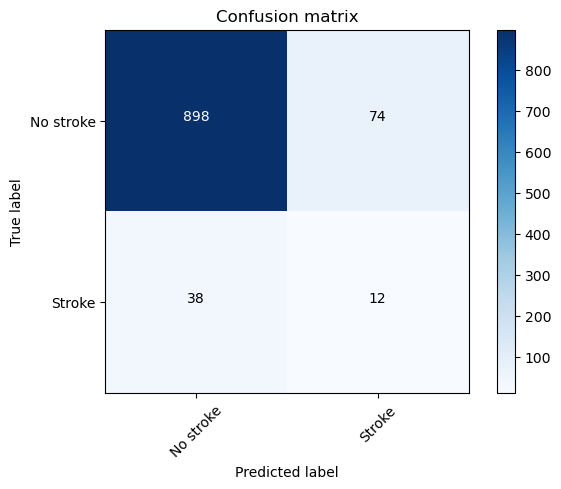

In [19]:
decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_leaf=11, min_samples_split=48, random_state=99)

decision_tree_model.fit(X_train, y_train)
y_pred = decision_tree_model.predict(X_test)
cm = utils.get_confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm=cm, classes=['No stroke', 'Stroke'])

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       972
           1       0.14      0.24      0.18        50

    accuracy                           0.89      1022
   macro avg       0.55      0.58      0.56      1022
weighted avg       0.92      0.89      0.90      1022



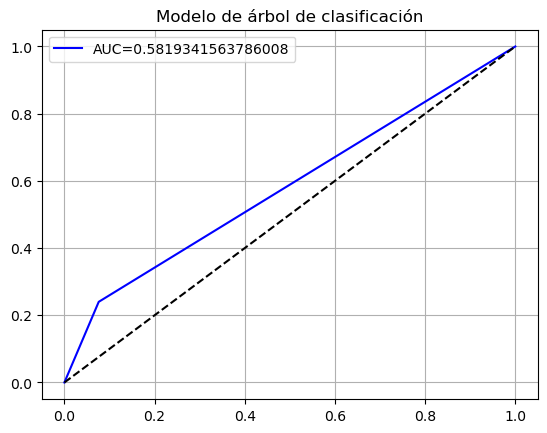

In [20]:
utils.print_metrics(y_test, y_pred, "Modelo de árbol de clasificación")

## Importancia de las variables

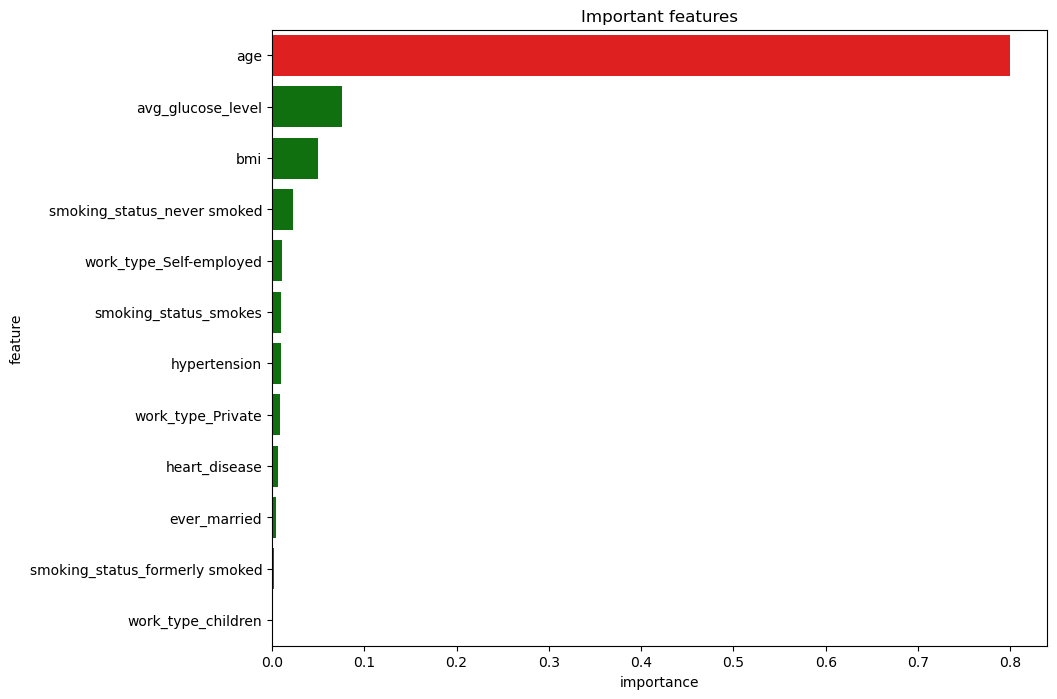

In [21]:
utils.plot_tree_feature_importance(decision_tree_model.feature_names_in_, decision_tree_model.feature_importances_)

## Árbol final

In [29]:
decision_tree_model.classes_

array([0, 1])

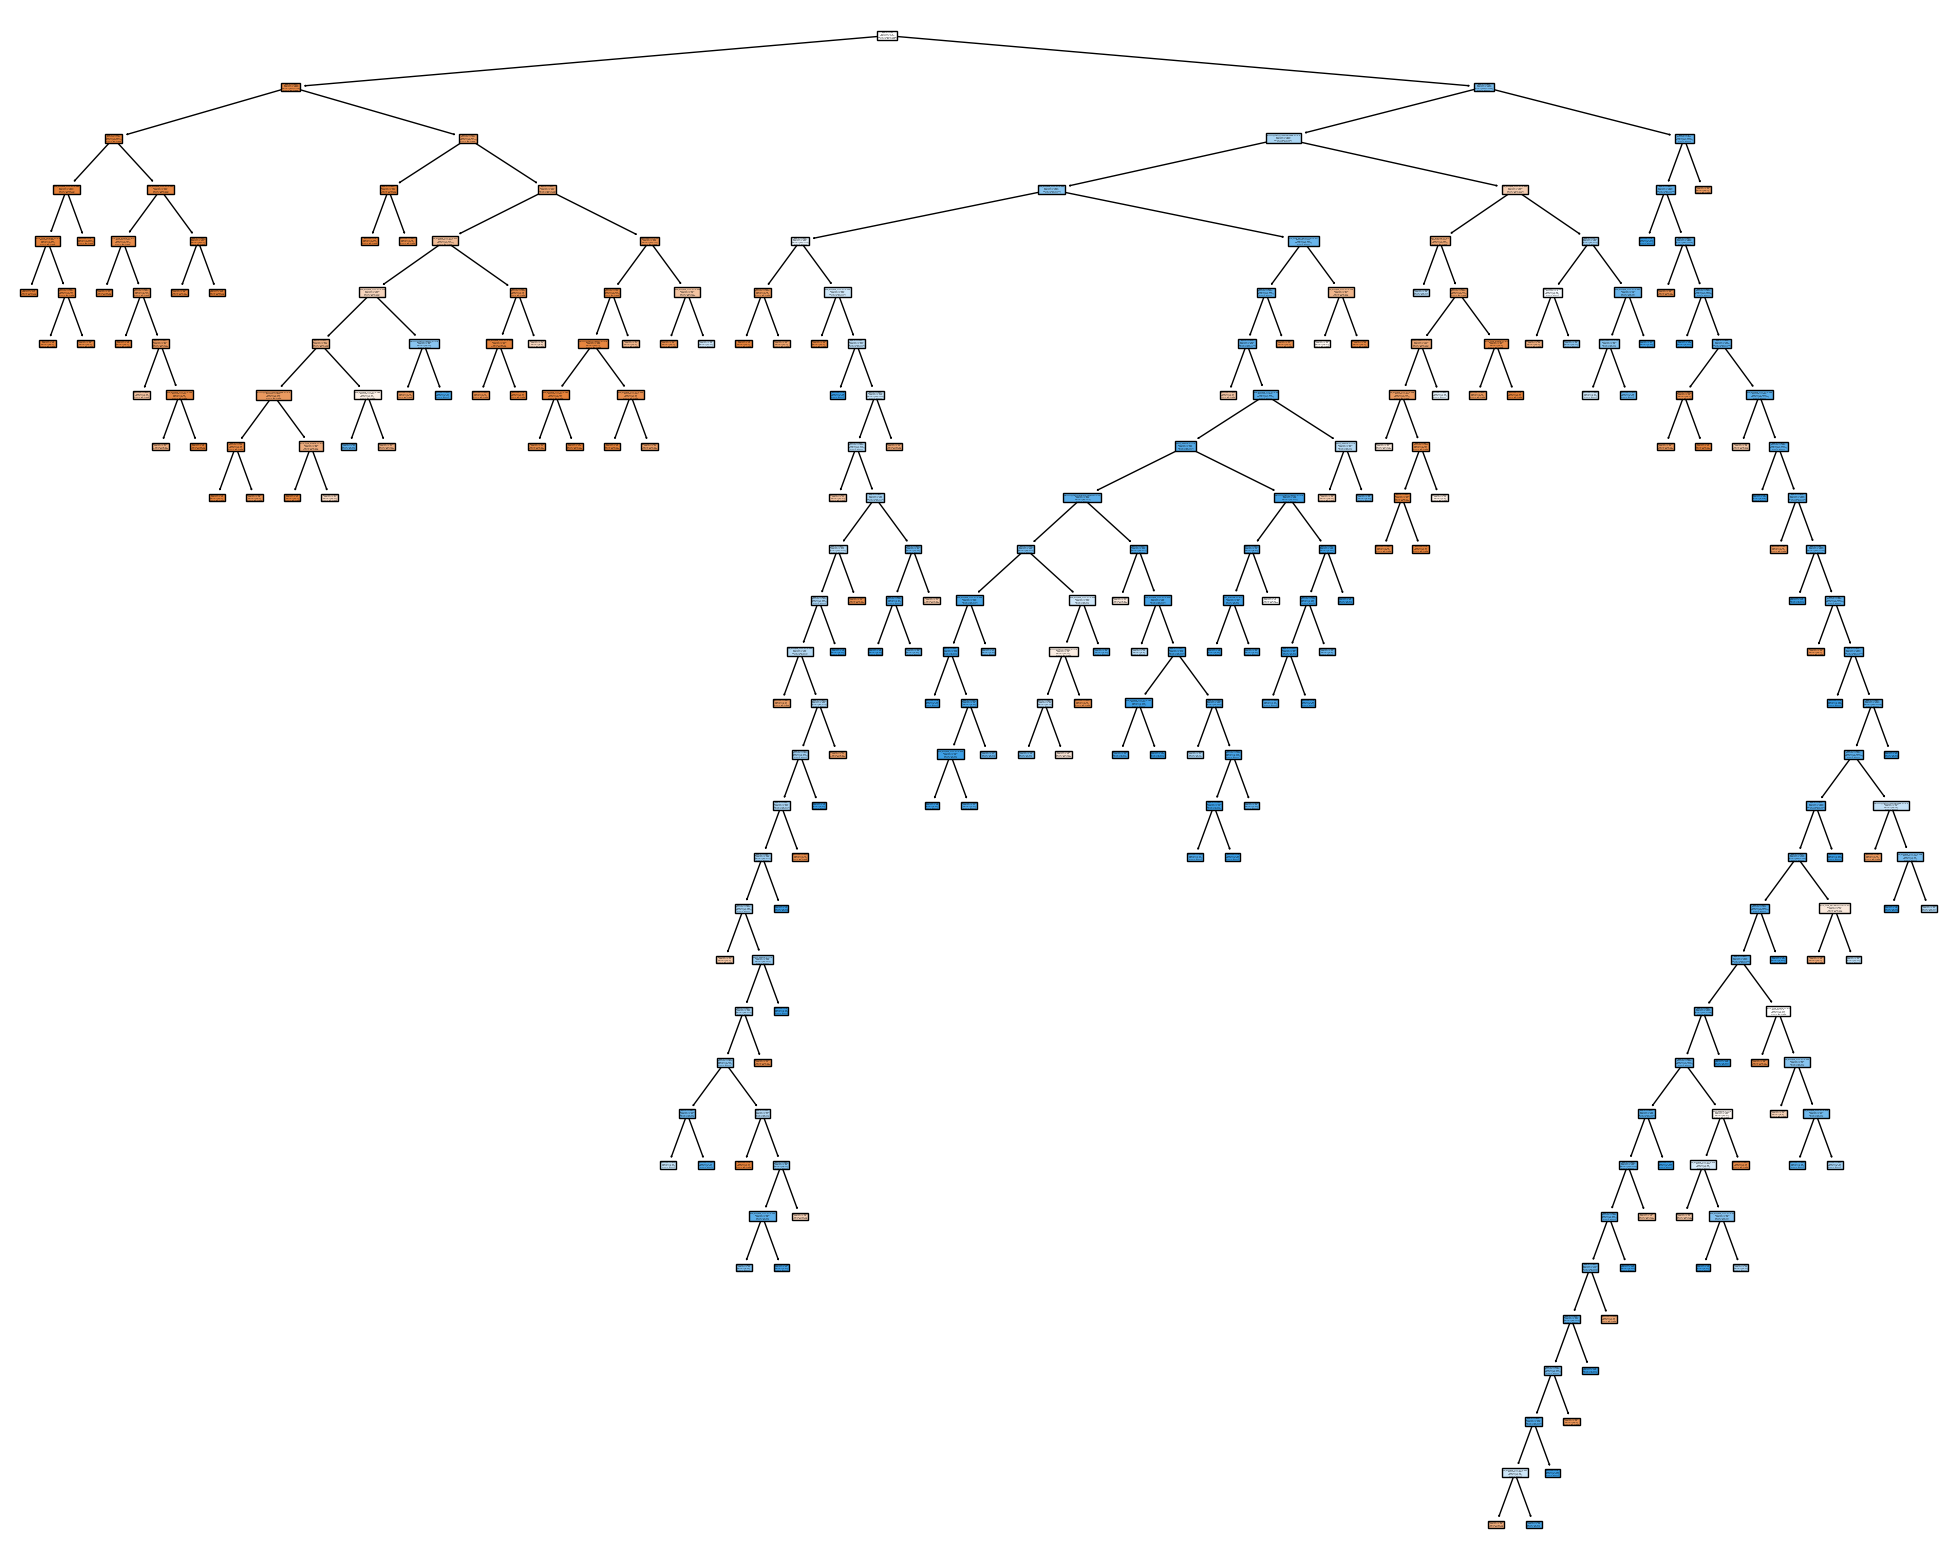

In [30]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_model, 
                   feature_names=decision_tree_model.feature_names_in_,  
                   class_names=['No stroke', 'Stroke'],
                   filled=True)

**Guardamos el modelo para la comparativa final**

In [31]:
pickle.dump(decision_tree_model, open("decision_tree_model.sav", 'wb'))